# Caracterização de Workload

Este Notebook tem o objetivo de analizar um arquivo de logs de um servidor web e realizar uma analise de caracterização de workload para teste levando em considerações os padrões de utilização.

### Grupo:
Leonardo Menezes <br>
Lucas <br>
Pedro Martins dos Santos

## Importando o arquivo de logs

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# Caminho do arquivo de log
log_file_path = 'access.log'

# Padrão regex para capturar informações válidas
regex_pattern = r'^(?P<client>\S+) \S+ (?P<userid>\S+) \[(?P<datetime>[^\]]+)\] "(?P<method>[A-Z]+) (?P<request>[^"]+)? HTTP/[0-9.]+" (?P<status>\d{3}) (?P<size>\d+|-) "(?P<referer>[^"]*)" "(?P<user_agent>[^"]*)"'

# Definição das colunas
columns = ['client', 'userid', 'datetime', 'method', 'request', 'status', 'size', 'referer', 'user_agent']

# Listas para armazenar entradas válidas e inválidas
valid_entries = []
invalid_entries = []

with open(log_file_path, 'r') as file:
    for i, line in enumerate(file):
        if i >= 1_000_000:  # Limite opcional para processar somente 1 milhão de linhas
            break
        match = re.match(regex_pattern, line)
        if match:
            valid_entries.append({
                'client': match.group('client'),
                'userid': match.group('userid'),
                'datetime': match.group('datetime'),
                'method': match.group('method'),
                'request': match.group('request'),
                'status': int(match.group('status')),
                'size': int(match.group('size')) if match.group('size') != '-' else 0,
                'referer': match.group('referer'),
                'user_agent': match.group('user_agent')
            })
        else:
            invalid_entries.append(line)

# Criação do DataFrame para entradas válidas
logs_df = pd.DataFrame(valid_entries, columns=columns)

# Salvar entradas inválidas para análise posterior
with open('invalid_entries.log', 'w') as invalid_file:
    for line in invalid_entries:
        invalid_file.write(line)

# Exibir informações gerais
print(f"Entradas válidas: {len(valid_entries)}")
print(f"Entradas inválidas: {len(invalid_entries)}")

Entradas válidas: 999997
Entradas inválidas: 3


## Removendo colunas que não usaremos

In [2]:
new_logs_df = logs_df.drop(["userid","method"], axis='columns')

In [3]:
new_logs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999997 entries, 0 to 999996
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   client      999997 non-null  object
 1   datetime    999997 non-null  object
 2   request     999997 non-null  object
 3   status      999997 non-null  int64 
 4   size        999997 non-null  int64 
 5   referer     999997 non-null  object
 6   user_agent  999997 non-null  object
dtypes: int64(2), object(5)
memory usage: 53.4+ MB


## Ajustando o Datetime

In [4]:
new_logs_df['datetime'] = pd.to_datetime(new_logs_df['datetime'], format='%d/%b/%Y:%H:%M:%S %z')

In [5]:
date = new_logs_df['datetime'].dt.minute
print(date)

0         56
1         56
2         56
3         56
4         56
          ..
999992    11
999993    11
999994    11
999995    11
999996    11
Name: datetime, Length: 999997, dtype: int32


In [6]:
teste_df = new_logs_df.groupby(['datetime']).count()
print(teste_df)

                           client  request  status  size  referer  user_agent
datetime                                                                     
2019-01-22 03:56:14+03:30       1        1       1     1        1           1
2019-01-22 03:56:16+03:30       2        2       2     2        2           2
2019-01-22 03:56:17+03:30       3        3       3     3        3           3
2019-01-22 03:56:18+03:30       5        5       5     5        5           5
2019-01-22 03:56:19+03:30       7        7       7     7        7           7
...                           ...      ...     ...   ...      ...         ...
2019-01-22 14:11:41+03:30      16       16      16    16       16          16
2019-01-22 14:11:42+03:30      32       32      32    32       32          32
2019-01-22 14:11:43+03:30      38       38      38    38       38          38
2019-01-22 14:11:44+03:30      39       39      39    39       39          39
2019-01-22 14:11:45+03:30      43       43      43    43       4

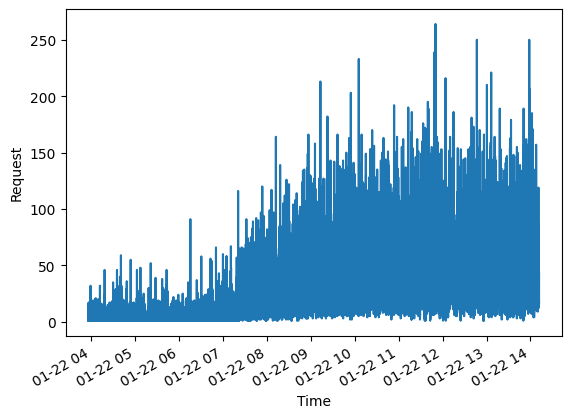

In [7]:
teste_df.request.plot()
plt.xlabel('Time')
plt.ylabel('Request')
plt.show()

## Histograma

<Axes: ylabel='Frequency'>

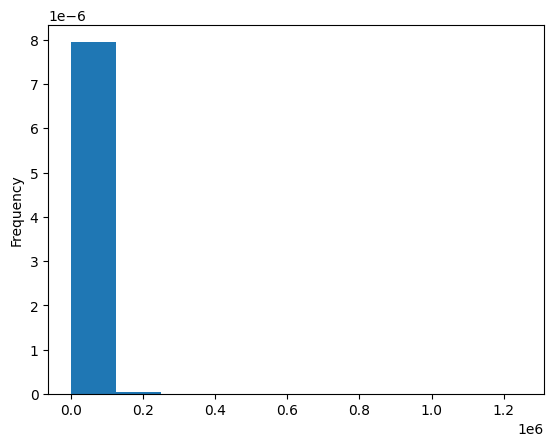

In [8]:
ylabel='Packet size'
new_logs_df["size"].plot(kind = 'hist', density=True)

## Quantidade de pacotes por tamanho

In [9]:
size_count  = new_logs_df['size'].value_counts()
display(size_count.head(20))

size
0        57863
11       30327
4120     28062
323      14074
28536     8919
6496      7160
7356      7111
5807      7064
6454      7046
7713      7042
7146      6798
4859      6674
3863      6631
133       5378
178       5203
5         4757
152       4253
217       4114
358       4066
393       4042
Name: count, dtype: int64

## Maiores pacotes

In [10]:
tamanho  = new_logs_df.sort_values(by='size',ascending=False)
display(tamanho.head(20))

,client,datetime,request,status,size,referer,user_agent
181242,40.77.167.13,2019-01-22 08:54:13+03:30,/image/5795?name=lg_13541539..3.png&wh=max,200,1249490,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
641245,207.46.13.199,2019-01-22 11:56:57+03:30,/image/5883?name=lg_1.....png&wh=max,200,1147355,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
910087,2.183.8.105,2019-01-22 13:38:00+03:30,/image/5801?name=er217%2C%2C%2C....png&wh=max,200,1126965,https://www.zanbil.ir/product/5801/6386/%D9%85...,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...
149279,185.180.53.254,2019-01-22 08:35:53+03:30,/image/5801?name=er217%2C%2C%2C....png&wh=max,200,1126965,https://www.zanbil.ir/product/5801/6386/%D9%85...,Mozilla/5.0 (Windows NT 6.1; rv:45.0) Gecko/20...
555609,185.110.28.34,2019-01-22 11:26:20+03:30,/image/5801?name=er217%2C%2C%2C....png&wh=max,200,1126965,https://www.zanbil.ir/product/5801/6386/%D9%85...,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
16767,172.20.2.174,2019-01-22 05:03:23+03:30,/EShopMonitor.exe.zip,200,912896,-,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
95866,66.249.66.92,2019-01-22 07:57:18+03:30,/image/23058?name=remington-xf8700-...png&wh=max,200,872883,-,Googlebot-Image/1.0
531728,5.233.53.65,2019-01-22 11:18:12+03:30,/image/get?path=/Image/er115%203.jpg,200,790454,https://www.zanbil.ir/product/5731/6284/%D9%85...,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...
730354,5.219.82.41,2019-01-22 12:31:35+03:30,/image/get?path=/Image/gfhh.png,200,776750,https://www.zanbil.ir/article/1092/%DB%8C%D8%A...,Mozilla/5.0 (Windows NT 6.2; Win64; x64) Apple...
47792,159.65.185.106,2019-01-22 06:54:15+03:30,/image/6408?name=es2265...png&wh=max,200,769091,https://www.zanbil.ir/m/product/6408/7377/%D9%...,Mozilla/5.0 (Linux; Android 6.0.1; SM-J710F) A...


## Quantidade de chamadas por Cliente

In [11]:
client_count  = new_logs_df['client'].value_counts()
display(client_count.head(20))

client
66.249.66.194      30860
66.249.66.91       19434
151.239.241.163    14311
91.99.30.32        14198
66.249.66.92        6592
23.101.169.3        6454
91.99.72.15         5213
40.77.167.170       4634
40.77.167.13        3823
46.224.113.43       3621
104.222.32.94       3528
2.178.8.199         2997
157.55.39.214       2536
207.46.13.9         2487
195.181.169.141     2450
94.183.36.205       2265
5.160.221.38        2220
194.94.127.7        2067
17.58.102.43        1992
5.113.178.57        1799
Name: count, dtype: int64

## Quantidade de Request por client

In [12]:
display(client_count.describe())

count    22844.000000
mean        43.775039
std        307.588074
min          1.000000
25%          1.000000
50%          3.000000
75%         32.000000
max      30860.000000
Name: count, dtype: float64

## Quantidade de Request por Status

In [13]:
status_count  = new_logs_df['status'].value_counts()
display(status_count.head(20))

status
200    941162
302     20308
304     19025
404      8116
301      5802
499      4625
403       587
500       257
502        35
400        29
401        28
408        21
504         2
Name: count, dtype: int64

## Códigos de Status HTTP
200 = Sucesso (OK) <br>
301 = Redirecionamento (Moved Permanently)<br>
302 = Redirecionamento (Found)<br>
304 = Redirecionamento (Not Modified)<br>
404 = Conteúdo não encontrado (Not Found)<br>

<Axes: xlabel='Status', ylabel='Quantidade'>

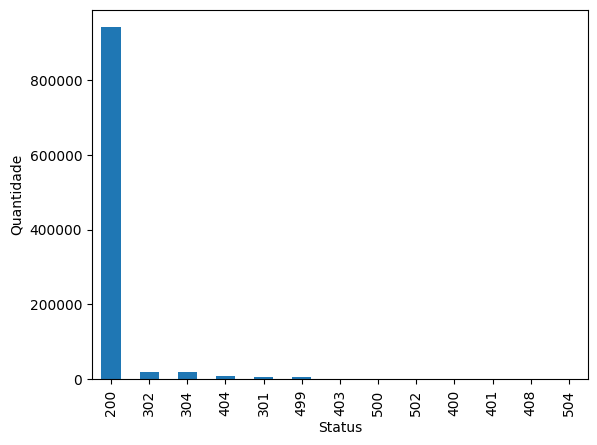

In [14]:
new_logs_df["status"].value_counts().plot(kind = 'bar', x='status', y='value', ylabel='Quantidade',xlabel='Status')

In [15]:
new_logs_df['datetime'] = pd.to_datetime(new_logs_df['datetime'], format='%d/%b/%Y:%H:%M:%S %z')
new_logs_df['hour'] = new_logs_df['datetime'].dt.hour

hourly_grouped = new_logs_df.groupby('hour').agg(
    total_requests=('request', 'count'),
    total_size=('size', 'sum'),
    avg_size=('size', 'mean'),
    max_size=('size', 'max'),
    status_500=('status', lambda x: (x == 500).sum()),
    status_304=('status', lambda x: (x == 304).sum()),
    status_302=('status', lambda x: (x == 302).sum()),
    status_404=('status', lambda x: (x == 404).sum()),
    status_301=('status', lambda x: (x == 301).sum()),
    status_499=('status', lambda x: (x == 499).sum()),
    status_403=('status', lambda x: (x == 403).sum()),
    status_502=('status', lambda x: (x == 502).sum()),
    status_400=('status', lambda x: (x == 400).sum()),
    status_401=('status', lambda x: (x == 401).sum()),
    status_408=('status', lambda x: (x == 408).sum()),
    status_504=('status', lambda x: (x == 504).sum()),
    status_405=('status', lambda x: (x == 405).sum()),
    status_206=('status', lambda x: (x == 206).sum()),
    status_200=('status', lambda x: (x == 200).sum()),

).reset_index()

print(hourly_grouped)

    hour  total_requests  total_size      avg_size  max_size  status_500  \
0      3            1285    23748265  18481.140078    185207           0   
1      4           14471   304924678  21071.431000    584470           1   
2      5           14867   322513139  21693.222506    912896           0   
3      6           19357   360752840  18636.815622    769091           0   
4      7           47800   641346913  13417.299435    872883           1   
5      8           95764  1113133811  11623.718840   1249490           3   
6      9          134248  1599281102  11912.885868    708115          95   
7     10          157091  1833425245  11671.103023    708098           4   
8     11          164407  2246610178  13664.930192   1147355          73   
9     12          160891  1787838956  11112.112896    776750          39   
10    13          161199  1756796716  10898.310262   1126965          35   
11    14           28617   331735862  11592.265507    576326           6   

    status_

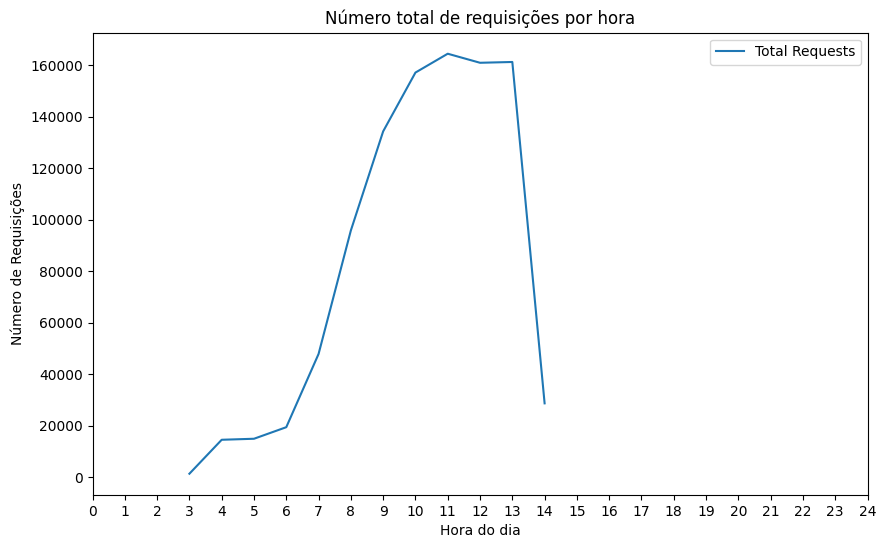

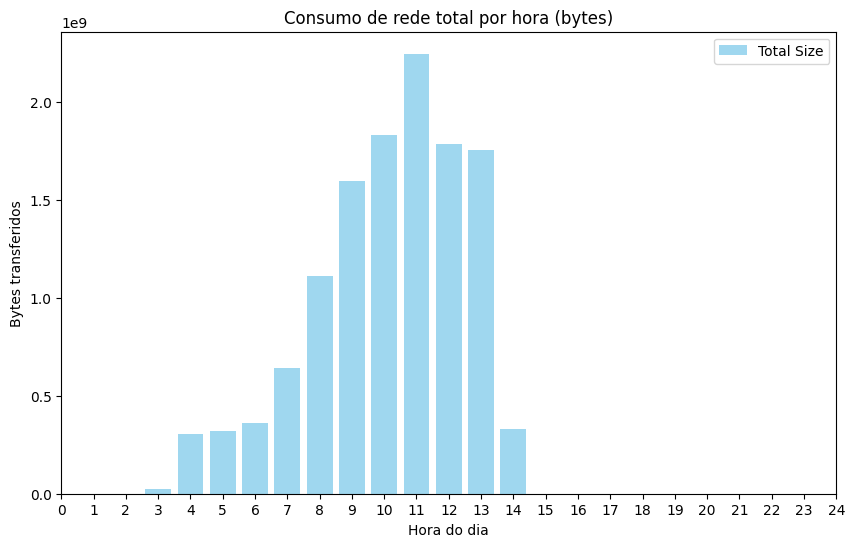

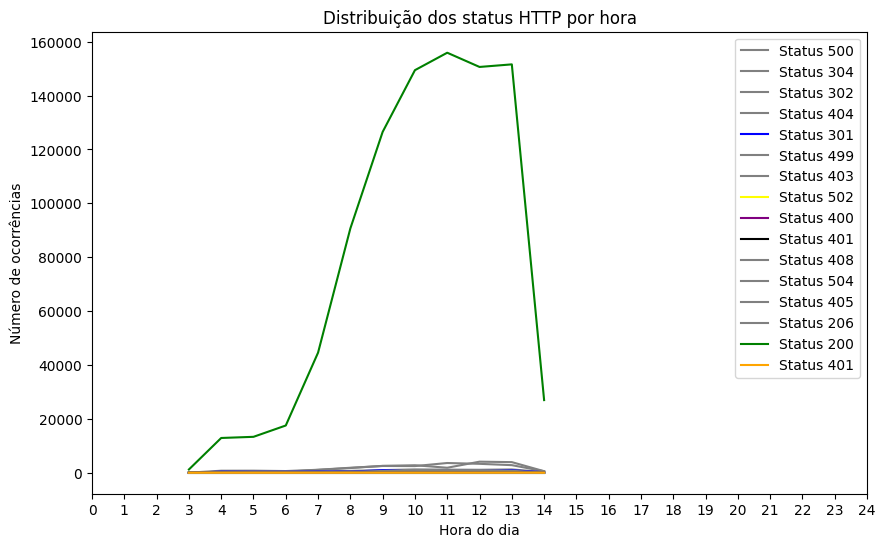

    hour     mean_size  median_size  variance_size  std_dev_size
0      3  18481.140078       7759.0   3.798091e+08  19488.690620
1      4  21071.431000      15350.0   1.099686e+09  33161.519989
2      5  21693.222506      19122.0   6.459301e+08  25415.155878
3      6  18636.815622       7669.0   6.581961e+08  25655.333746
4      7  13417.299435       4167.0   5.497866e+08  23447.528261
5      8  11623.718840       3743.0   5.505433e+08  23463.659301
6      9  11912.885868       3538.0   6.319214e+08  25138.046323
7     10  11671.103023       3357.0   7.945989e+08  28188.629843
8     11  13664.930192       3454.0   1.854964e+09  43069.293012
9     12  11112.112896       3300.0   7.598529e+08  27565.430192
10    13  10898.310262       3482.0   5.800741e+08  24084.726832
11    14  11592.265507       3767.0   7.082433e+08  26612.841129


In [17]:
plt.style.use('default')

# Número total de requisições por hora
plt.figure(figsize=(10, 6))
plt.plot(hourly_grouped['hour'], hourly_grouped['total_requests'], label='Total Requests')
plt.title('Número total de requisições por hora')
plt.xlabel('Hora do dia')
plt.ylabel('Número de Requisições')
plt.xticks(range(0, 25))
plt.legend()
plt.show()

# Consumo total de rede por hora
plt.figure(figsize=(10, 6))
plt.bar(hourly_grouped['hour'], hourly_grouped['total_size'], color='skyblue', alpha=0.8, label='Total Size')
plt.title('Consumo de rede total por hora (bytes)')
plt.xlabel('Hora do dia')
plt.ylabel('Bytes transferidos')
plt.xticks(range(0, 25))
plt.legend()
plt.show()

# Distribuição dos status HTTP por hora
plt.figure(figsize=(10, 6))
plt.plot(hourly_grouped['hour'], hourly_grouped['status_500'], label='Status 500', color='gray')
plt.plot(hourly_grouped['hour'], hourly_grouped['status_304'], label='Status 304', color='gray')
plt.plot(hourly_grouped['hour'], hourly_grouped['status_302'], label='Status 302', color='gray')
plt.plot(hourly_grouped['hour'], hourly_grouped['status_404'], label='Status 404', color='gray')
plt.plot(hourly_grouped['hour'], hourly_grouped['status_301'], label='Status 301', color='blue')
plt.plot(hourly_grouped['hour'], hourly_grouped['status_499'], label='Status 499', color='gray')
plt.plot(hourly_grouped['hour'], hourly_grouped['status_403'], label='Status 403', color='gray')
plt.plot(hourly_grouped['hour'], hourly_grouped['status_502'], label='Status 502', color='yellow')
plt.plot(hourly_grouped['hour'], hourly_grouped['status_400'], label='Status 400', color='purple')
plt.plot(hourly_grouped['hour'], hourly_grouped['status_401'], label='Status 401', color='black')
plt.plot(hourly_grouped['hour'], hourly_grouped['status_408'], label='Status 408', color='gray')
plt.plot(hourly_grouped['hour'], hourly_grouped['status_504'], label='Status 504', color='gray')
plt.plot(hourly_grouped['hour'], hourly_grouped['status_405'], label='Status 405', color='gray')
plt.plot(hourly_grouped['hour'], hourly_grouped['status_206'], label='Status 206', color='gray')
plt.plot(hourly_grouped['hour'], hourly_grouped['status_200'], label='Status 200', color='green')

plt.plot(hourly_grouped['hour'], hourly_grouped['status_401'], label='Status 401', color='orange')
plt.title('Distribuição dos status HTTP por hora')
plt.xlabel('Hora do dia')
plt.ylabel('Número de ocorrências')
plt.xticks(range(0, 25))
plt.legend()
plt.show()

hourly_summary = new_logs_df.groupby('hour').agg(
    mean_size=('size', 'mean'),
    median_size=('size', 'median'),
    variance_size=('size', 'var'),
    std_dev_size=('size', 'std')  
).reset_index()

print(hourly_summary)

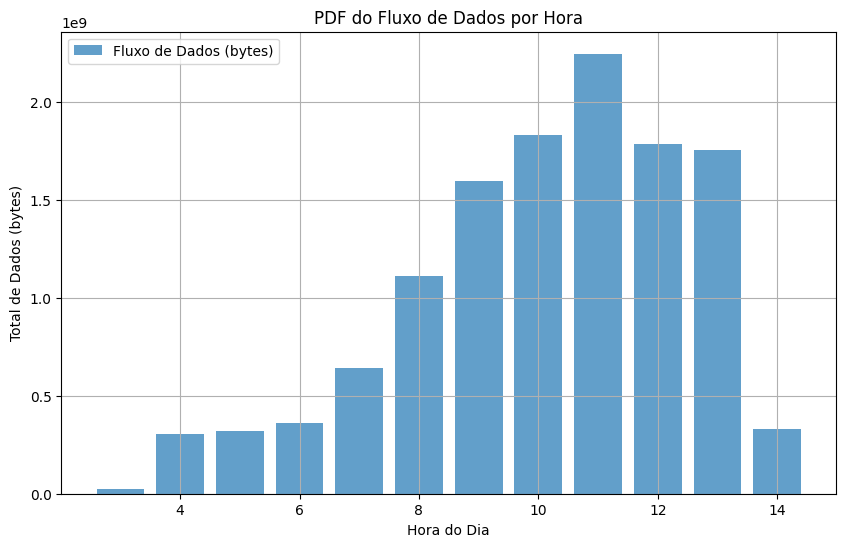

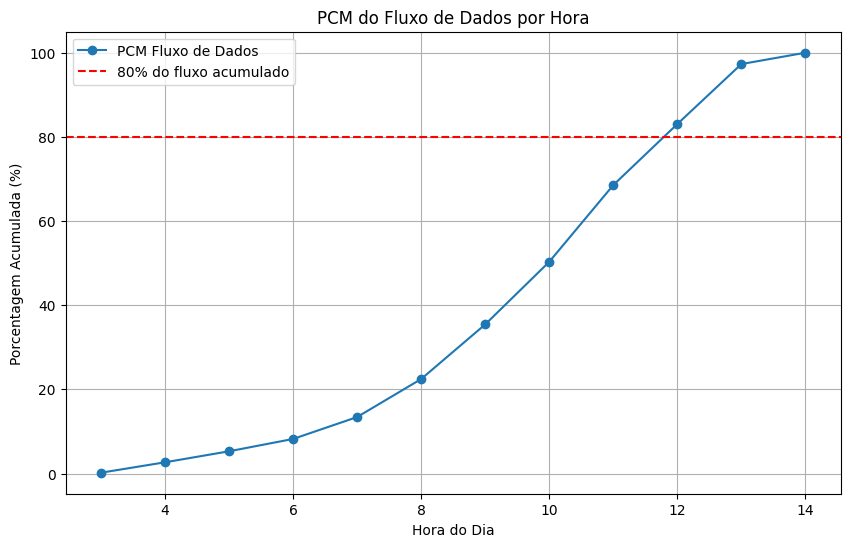

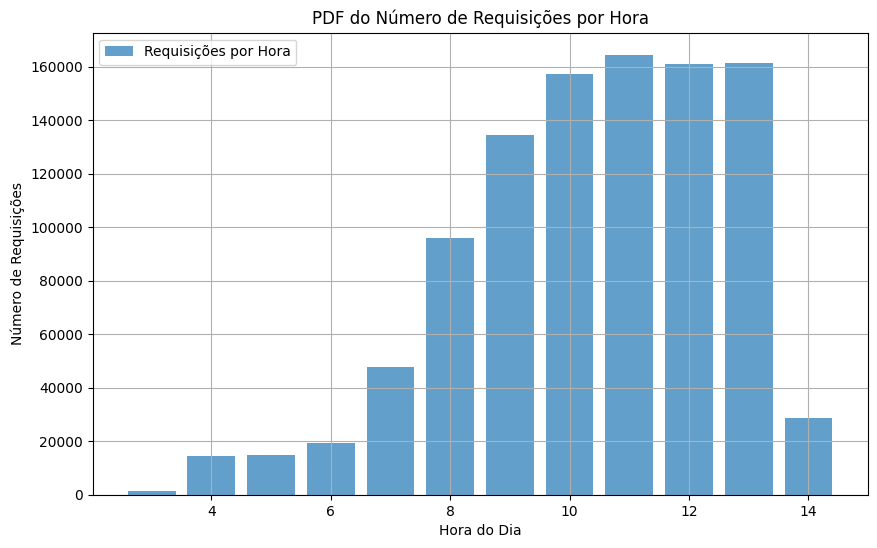

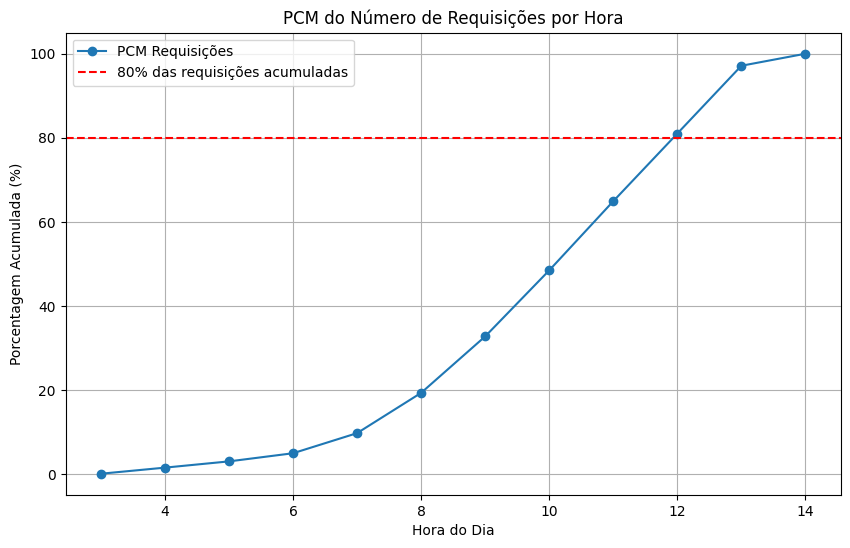

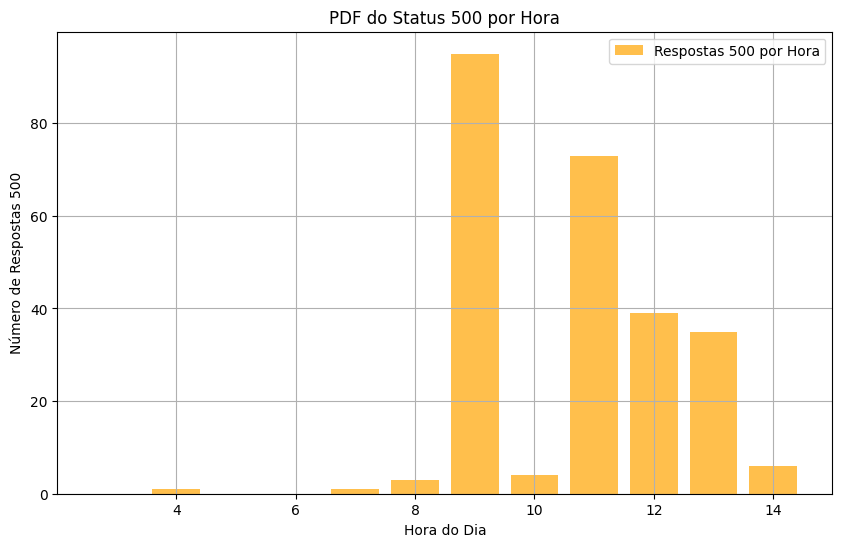

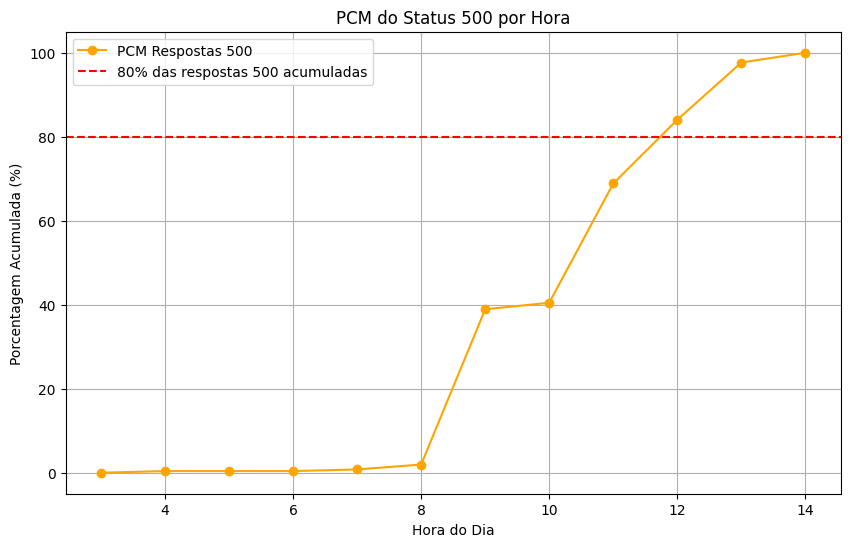

In [78]:
import numpy as np
import matplotlib.pyplot as plt

# Agrupar dados por hora
new_logs_df['hour'] = new_logs_df['datetime'].dt.hour
hourly_data = new_logs_df.groupby('hour').agg(
    total_size=('size', 'sum'),  # Fluxo total de dados
    request_count=('size', 'count'),  # Total de requisições
    status_count_500=('status', lambda x: (x == 500).sum()),  # Total de respostas 500
    status_count_401=('status', lambda x: (x == 401).sum())   # Total de respostas 401
).reset_index()

# 1. PDF do fluxo de dados por hora
plt.figure(figsize=(10, 6))
plt.bar(hourly_data['hour'], hourly_data['total_size'], alpha=0.7, label='Fluxo de Dados (bytes)')
plt.title('PDF do Fluxo de Dados por Hora')
plt.xlabel('Hora do Dia')
plt.ylabel('Total de Dados (bytes)')
plt.grid(True)
plt.legend()
plt.show()

# 2. PCM do fluxo de dados por hora
cumulative_size = np.cumsum(hourly_data['total_size']) / np.sum(hourly_data['total_size']) * 100

plt.figure(figsize=(10, 6))
plt.plot(hourly_data['hour'], cumulative_size, marker='o', label='PCM Fluxo de Dados')
plt.axhline(80, color='red', linestyle='--', label='80% do fluxo acumulado')
plt.title('PCM do Fluxo de Dados por Hora')
plt.xlabel('Hora do Dia')
plt.ylabel('Porcentagem Acumulada (%)')
plt.grid(True)
plt.legend()
plt.show()

# 3. PDF do número de requisições por hora
plt.figure(figsize=(10, 6))
plt.bar(hourly_data['hour'], hourly_data['request_count'], alpha=0.7, label='Requisições por Hora')
plt.title('PDF do Número de Requisições por Hora')
plt.xlabel('Hora do Dia')
plt.ylabel('Número de Requisições')
plt.grid(True)
plt.legend()
plt.show()

# 4. PCM do número de requisições por hora
cumulative_requests = np.cumsum(hourly_data['request_count']) / np.sum(hourly_data['request_count']) * 100

plt.figure(figsize=(10, 6))
plt.plot(hourly_data['hour'], cumulative_requests, marker='o', label='PCM Requisições')
plt.axhline(80, color='red', linestyle='--', label='80% das requisições acumuladas')
plt.title('PCM do Número de Requisições por Hora')
plt.xlabel('Hora do Dia')
plt.ylabel('Porcentagem Acumulada (%)')
plt.grid(True)
plt.legend()
plt.show()

# 5. PDF do status das respostas 500 por hora
plt.figure(figsize=(10, 6))
plt.bar(hourly_data['hour'], hourly_data['status_count_500'], alpha=0.7, label='Respostas 500 por Hora', color='orange')
plt.title('PDF do Status 500 por Hora')
plt.xlabel('Hora do Dia')
plt.ylabel('Número de Respostas 500')
plt.grid(True)
plt.legend()
plt.show()

# 6. PCM do status das respostas 500 por hora
cumulative_500 = np.cumsum(hourly_data['status_count_500']) / np.sum(hourly_data['status_count_500']) * 100

plt.figure(figsize=(10, 6))
plt.plot(hourly_data['hour'], cumulative_500, marker='o', label='PCM Respostas 500', color='orange')
plt.axhline(80, color='red', linestyle='--', label='80% das respostas 500 acumuladas')
plt.title('PCM do Status 500 por Hora')
plt.xlabel('Hora do Dia')
plt.ylabel('Porcentagem Acumulada (%)')
plt.grid(True)
plt.legend()
plt.show()
